In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device=('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df=pd.read_csv('data/wine.csv', header=None)
X=df.iloc[:, :-1]
y=df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [4]:
def df_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

In [5]:
X_train=df_to_tensor(X_train)
X_test=df_to_tensor(X_test)
y_train=df_to_tensor(y_train)
y_test=df_to_tensor(y_test)

In [6]:
class Wine(nn.Module):
    def __init__(self):
        super(Wine, self).__init__()
        
        self.hidden_linear1=nn.Linear(12, 30)
        self.hidden_linear2=nn.Linear(30, 12)
        self.hidden_linear3=nn.Linear(12, 8)
        self.output_linear=nn.Linear(8, 1)
    
    def forward(self, input):
        out = torch.relu(self.hidden_linear1(input))
        out = torch.relu(self.hidden_linear2(out))
        out = torch.relu(self.hidden_linear3(out))
        out = torch.sigmoid(self.output_linear(out))
        
        return out

In [7]:
model=Wine().to(device)
model

Wine(
  (hidden_linear1): Linear(in_features=12, out_features=30, bias=True)
  (hidden_linear2): Linear(in_features=30, out_features=12, bias=True)
  (hidden_linear3): Linear(in_features=12, out_features=8, bias=True)
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [8]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.-- loss 가 min
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):
        
        #__init__ 메서드는 클래스의 인스턴스를 초기화하기 위해 사용됩니다. 이는 새로운 객체, 즉 인스턴스를 생성할 때 호출되는 메서드입니다. 반면에,
        #__call__ 메서드는 인스턴스를 함수처럼 호출 가능하게 만듭니다.
        #기억해야 할 것은 __init__은 객체가 생성될 때 한 번 호출된다는 것입니다. 그러나 __call__은 인스턴스가 호출될 때마다 여러 번 호출될 수 있습니다.

        if self.best_score is None: # X 왜냐면 infinity or 0
            self.best_score = score
            self.counter = 0 #patience counting 
        elif self.mode == 'min':
            if score < (self.best_score - self.delta): #loss < infinity - 0
                self.counter = 0
                self.best_score = score
                if self.verbose: #verbose= True
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else: #loss 값이 작아지지 않을 경우
                self.counter += 1 #patience 증가
                # if self.verbose:
                #     print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                #           f'Best: {self.best_score:.5f}' \
                #           f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max': #accuracy 셀 때 max
            if score > (self.best_score + self.delta): #loss < 0+ 0
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                # if self.verbose:
                #     print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                #           f'Best: {self.best_score:.5f}' \
                #           f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [9]:
def model_validation(model, dataloader):
    correct = 0
    with torch.no_grad():
        for data, label in dataloader:
            pred = model(data.to(device))
            result = pred.squeeze(1).ge(torch.tensor(0.5).to(device))
            correct += result.long().eq(label.to(device)).sum().item()
    return (correct / len(dataloader.dataset))

In [10]:
#model 전체 저장
torch.save(model.state_dict(), 'model/wine.pth')

In [11]:
#하다가 중지 시켜놓고 다시 불러오려면 가중치와 bias parameter만 저장해서는 안됨, epoch와 optimizer의 상태와 그 순간의 loss 값도 저장 필요
def model_check_point(epoch, loss, model_path, boundary):
    if loss.item() < boundary:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_path)
        return loss.item()
    else:
        return boundary

In [12]:
#위와 같이 했을 때
checkpoint = torch.load('load/from/path/model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

FileNotFoundError: [Errno 2] No such file or directory: 'load/from/path/model.pth'

In [13]:
def model_check_point(loss, model_path, boundary):
    if loss.item() < boundary: #boundary: 이전 loss 값
        torch.save( model.state_dict(), model_path) #state_dict 는 간단히 말해 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체 -- 가중치와 bias parameter
        return loss.item()
    else:
        return boundary

In [14]:
early_stopping=EarlyStopping(patience=3, delta=0, mode='min', verbose=True) #default 값이니까 굳이 parameter 넣어주지 않아도 됨

In [15]:
ds=TensorDataset(X_train, y_train)
dataloader=DataLoader(ds, batch_size=200)

val_ds=TensorDataset(X_test, y_test)
val_loader=DataLoader(val_ds)

optimizer=optim.Adam(model.parameters())

loss_fn=nn.BCELoss()

n_epochs=1000
loss=0.0

save_loss=1.0

list_accuracy=[]
list_loss=[]

for epoch in range(n_epochs+1):
    model.train()
    for data, label in dataloader:
        #data = data.type(torch.FloatTensor)
        out = model(data.to(device))
        loss = loss_fn(out, label.unsqueeze(1).float().to(device))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = model_validation(model, val_loader)
    
    model_path = "model/wine-best.pth"
    
    save_loss = model_check_point(loss, model_path, save_loss) #저장된 손실 return
    
    list_loss.append(loss.detach().cpu()) #loss가 gpu에 있을 때 cpu로 옮김 (.detach()) 역전파 사슬을 끊겠다 -- 끊은 상태에서만 옮겨짐 
    list_accuracy.append(accuracy)
    
    if epoch % 20 == 0:
            print(f"Epoch {epoch}, Training loss {loss:.4f},")
            print("Validation Accuracy: %f" % accuracy)
            
    early_stopping(loss.item()) #__call__
    if early_stopping.early_stop:
        break

Epoch 0, Training loss 0.3775,
Validation Accuracy: 0.761538
[EarlyStopping] (Update) Best Score: 0.37753
[EarlyStopping] (Update) Best Score: 0.32274
[EarlyStopping] (Update) Best Score: 0.28003
[EarlyStopping] (Update) Best Score: 0.24683
[EarlyStopping] (Update) Best Score: 0.21821
[EarlyStopping] (Update) Best Score: 0.19917
[EarlyStopping] (Update) Best Score: 0.18700
[EarlyStopping] (Update) Best Score: 0.17921
[EarlyStopping] (Update) Best Score: 0.17453
[EarlyStopping] (Update) Best Score: 0.17106
[EarlyStopping] (Update) Best Score: 0.16778
[EarlyStopping] (Update) Best Score: 0.16395
[EarlyStopping] (Update) Best Score: 0.16107
[EarlyStopping] (Update) Best Score: 0.15662
[EarlyStopping] (Update) Best Score: 0.15377
[EarlyStopping] (Update) Best Score: 0.15149
[EarlyStopping] (Update) Best Score: 0.14792
[EarlyStopping] (Update) Best Score: 0.14415
[EarlyStopping] (Update) Best Score: 0.14113
[EarlyStopping] (Update) Best Score: 0.13814
Epoch 20, Training loss 0.1343,
Validat

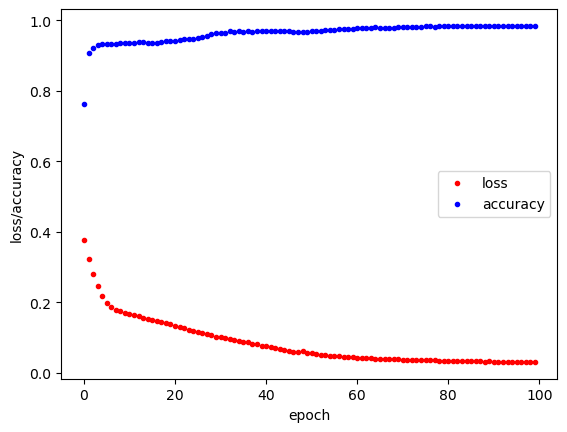

In [16]:
x_len = np.arange(len(list_loss))
plt.plot(x_len, list_loss, "o", c="red", markersize=3, label='loss')
plt.plot(x_len, list_accuracy, "o", c="blue", markersize=3, label='accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend()
plt.show()